# TSA Predictions Model

This is me building/testing models to predict TSA wait times, for incorporation into the How Is MCO Today Calculator Tool.

In [4]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

## Data Cleaning

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/cruzdariel/how_is_mco_today/refs/heads/main/history.csv")

In [6]:
def safe_literal_eval(val):
	if isinstance(val, str):
		return ast.literal_eval(val)
	return val

df['cancelled_by_airline'] = df['cancelled_by_airline'].apply(safe_literal_eval)
df['delayed_by_airline'] = df['delayed_by_airline'].apply(safe_literal_eval)
df['lane_wait_times'] = df['lane_wait_times'].apply(safe_literal_eval)

cancelled_df = pd.json_normalize(df['cancelled_by_airline'])
delayed_df = pd.json_normalize(df['delayed_by_airline'])
waits_df = pd.json_normalize(df['lane_wait_times'])

cancelled_df = cancelled_df.fillna(0).astype(int)
delayed_df = delayed_df.fillna(0).astype(int)
waits_df = waits_df.fillna(0)
numeric_cols = [col for col in waits_df.columns if 'wait_time' in col]
waits_df[numeric_cols] = waits_df[numeric_cols].astype(int)

cancelled_df.columns = [f"cancelled_{col}" for col in cancelled_df.columns]
delayed_df.columns = [f"delayed_{col}" for col in delayed_df.columns]
waits_df.columns = [f"tsa_{col}" for col in waits_df.columns]

df = df.join(cancelled_df).join(delayed_df).join(waits_df)
df['timestamp'] = pd.to_datetime(df['timestamp'], format="mixed")
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df.head(1)

,timestamp,score_metric,most_delayed,most_cancelled,delayed_by_airline,cancelled_by_airline,delayed,cancelled,ontime,total_flights,...,tsa_South Checkpoint General.wait_time,tsa_South Checkpoint TSA PreCheck.lane_type,tsa_South Checkpoint TSA PreCheck.wait_time,tsa_West Checkpoint General.lane_type,tsa_West Checkpoint General.wait_time,year,month,day,hour,minute
0,2025-02-16 19:23:50,0.551954,Southwest,Frontier,"{'United': 10, 'American': 8, 'JetBlue': 12, '...","{'American': 1, 'Frontier': 4}",72,5,49,126,...,5,tsa_precheck,2,general,8,2025,2,16,19,23


In [7]:
df_clean = pd.read_csv("mcodemandclean.csv")
df_clean = df_clean.drop(columns=["timestamp","year","Time ID","month"])
df_clean.head()

,day,hour,Is Night,Is Morning,Is Monday,Is Tuesday,Is Wednesday,Is Thursday,Is Friday,Is Saturday,...,Gates 1-29 Seat Profile,Gates 100-129 Seat Profile,Gates 30-59 Seat Profile,Gates 70-99 Seat Profile,Gates 230-245 Seat Profile,Gates 1-29 Security Demand,Gates 100-129 Security Demand,Gates 30-59 Security Demand,Gates 70-99 Security Demand,Gates 230-245 Security Demand
0,7,19,0,0,0,0,0,0,0,0,...,790.0,1511.0,201.0,1816.0,762,920.5,1473.0,201.0,657.5,1384.5
1,7,19,0,0,0,0,0,0,0,0,...,790.0,1511.0,201.0,1816.0,762,920.5,1473.0,201.0,657.5,1384.5
2,7,23,0,0,0,0,0,0,0,0,...,1301.0,318.0,0.0,0.0,522,362.0,0.0,0.0,0.0,0.0
3,1,9,0,0,0,0,0,0,0,0,...,2039.0,1479.0,1101.5,1952.0,524,1057.0,2040.5,1101.5,599.5,921.5
4,1,19,1,1,1,0,0,0,0,0,...,784.0,1718.0,276.5,1616.0,745,1104.5,1951.5,276.5,657.5,1671.5


In [8]:
df_dummies = pd.get_dummies(df_clean, columns=['day', 'hour','most_delayed', 'most_cancelled'], drop_first=True)
df_dummies.fillna(0, inplace=True)
df_dummies = df_dummies.replace("#NUM!", np.nan)
df_dummies.head()

,Is Night,Is Morning,Is Monday,Is Tuesday,Is Wednesday,Is Thursday,Is Friday,Is Saturday,Is Sunday,Is Weekend,...,most_cancelled_JetBlue,most_cancelled_Porter,most_cancelled_Silver Airways,most_cancelled_Southwest,most_cancelled_Spirit,most_cancelled_Sun Country,most_cancelled_United,most_cancelled_Virgin Atlantic,most_cancelled_Volaris,most_cancelled_WestJet
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,0,0,0,0,0,1,1,...,False,False,False,False,False,False,False,False,False,False
4,1,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [9]:
corr_with_overall_wait = df_dummies.corr()['average_overall_wait'].sort_values(ascending=False)

display(corr_with_overall_wait)

average_overall_wait                     1.000000
average_general_wait                     0.992516
tsa_West Checkpoint General.wait_time    0.849310
tsa_East Checkpoint General.wait_time    0.787705
total_flights                            0.643483
                                           ...   
Bad Day                                 -0.173182
hour_2                                  -0.189305
hour_23                                 -0.203213
hour_22                                 -0.205859
hour_1                                  -0.242868
Name: average_overall_wait, Length: 167, dtype: float64

Dropping waits because they are posing a major data leak issue for the model.

In [11]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

y = df_dummies['average_overall_wait']
X = df_dummies.drop(columns=['average_overall_wait', 'tsa_West Checkpoint General.wait_time', 'tsa_East Checkpoint General.wait_time', 
                    'average_general_wait', 'tsa_South Checkpoint General.wait_time', 'average_precheck_wait', 'score_metric',
                    'Gates 70-99 Seat Profile', 'Gates 100-129 Seat Profile', 'delayed_Spirit', 'delayed_Frontier', 'delayed_American', 
                    'Gates 30-59 Security Demand', 'Gates 30-59 Seat Profile', 'delayed_United', 'cancelled', 'cancelled_Avianca', 'Is Monday', 
                    'delayed_Air Canada', 'delayed_Emirates', 'delayed_Alaska', 'cancelled_Southwest', 'cancelled_United', 'delayed_Breeze Airways', 
                    'delayed_Silver Airways', 'Is Thursday', 'cancelled_Silver Airways', 'delayed_LAN Chile', 'cancelled_American', 'Is Morning', 
                    'delayed_Avelo Airlines', 'Is Wednesday', 'Is Night', 'delayed_Porter', 'delayed_WestJet', 'Is Weekend', 'cancelled_Frontier', 
                    'cancelled_Spirit', 'delayed_Avianca', 'Is Tuesday', 'Is Friday', 'delayed_Discover', 'cancelled_Flair', 'Is Saturday', 
                    'delayed_Sun Country', 'cancelled_JetBlue', 'delayed_Allegiant Air', 'delayed_Virgin Atlantic', 'delayed_Copa Airlines', 
                    'Ok Day', 'Good Day', 'delayed_Aeromexico', 'delayed_Flair', 'cancelled_Delta', 'cancelled_Breeze Airways', 'cancelled_Air Canada', 
                    'delayed_British Airways', 'delayed_Air Transat', 'cancelled_Sun Country', 'cancelled_Discover', 'delayed_Norse Atlantic UK', 
                    'delayed_Aer Lingus', 'cancelled_Azul', 'cancelled_Virgin Atlantic', 'cancelled_Porter', 'delayed_Vivaaerobus', 'delayed_GOL', 
                    'delayed_Azul', 'delayed_Latam Colombia', 'Bad Day', 'cancelled_Alaska', 'delayed_Bahamasair', 'delayed_Volaris', 'cancelled_Volaris', 
                    'cancelled_Aeromexico', 'delayed_BermudAir', 'cancelled_Copa Airlines', 'cancelled_GOL', 'cancelled_WestJet', 'cancelled_Icelandair', 
                    'delayed_LATAM'])
X = X.select_dtypes(include=[np.number])

pipelines = {
    #"LinearRegression": make_pipeline(StandardScaler(), LinearRegression()),
    #"RandomForest": make_pipeline(RandomForestRegressor(random_state=42, n_estimators=200)),  
    #"SVR": make_pipeline(StandardScaler(), SVR()),
    #"Lasso": make_pipeline(StandardScaler(), Lasso(alpha=1.0)),
    "NeuralNetwork": make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=600, early_stopping=True, learning_rate_init=0.01)) # 500 original max iter
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    scores_r2 = cross_val_score(pipeline, X, y, cv=kf, scoring='r2')
    print(f"{name}: R² = {np.mean(scores_r2):.2f} (+/- {np.std(scores_r2):.2f})")
    
    scores_rmse = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    print(f"{name}: RMSE = {-np.mean(scores_rmse):.2f} (+/- {np.std(scores_rmse):.2f})")
    
    scores_mae = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_absolute_error')
    print(f"{name}: MAE = {-np.mean(scores_mae):.2f} (+/- {np.std(scores_mae):.2f})\n")

NeuralNetwork: R² = 0.57 (+/- 0.03)
NeuralNetwork: RMSE = 2.43 (+/- 0.10)
NeuralNetwork: MAE = 1.74 (+/- 0.05)



In [12]:
# Hyperparameter Tuning with GridSearchCV for RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_rf = make_pipeline(RandomForestRegressor(random_state=42))
param_grid = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters for RandomForest:", grid_rf.best_params_)
print("Best MAE (from CV):", -grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)

Best parameters for RandomForest: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 200}
Best MAE (from CV): 1.4826966228289835


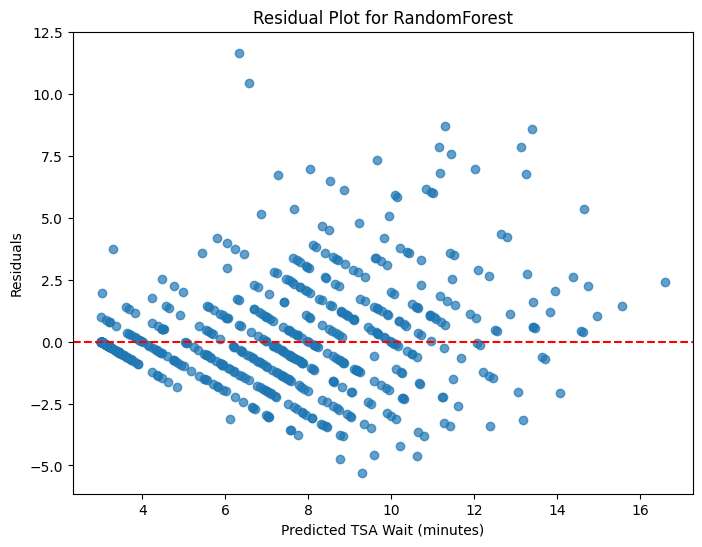

In [13]:
# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel("Predicted TSA Wait (minutes)")
plt.ylabel("Residuals")
plt.title("Residual Plot for RandomForest")
plt.axhline(0, color='red', linestyle='--')
plt.show()

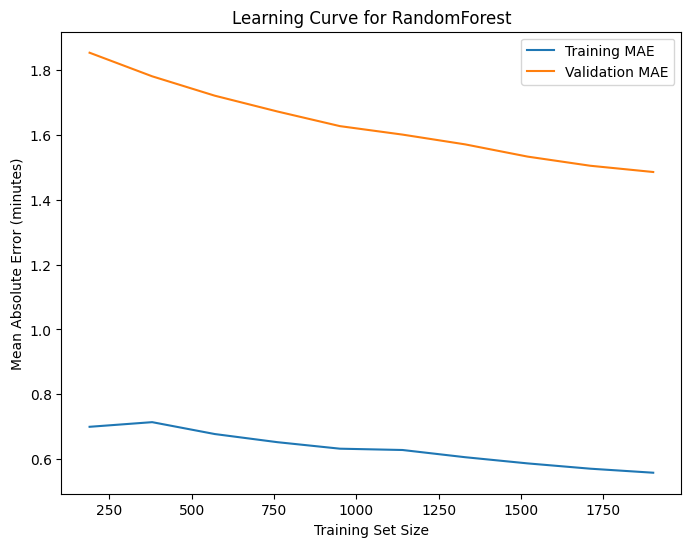

In [14]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_scores_mean = -np.mean(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label="Training MAE")
plt.plot(train_sizes, val_scores_mean, label="Validation MAE")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (minutes)")
plt.title("Learning Curve for RandomForest")
plt.legend()
plt.show()

                                        feature  importance
3                                 total_flights    0.454006
2                                        ontime    0.079977
1                                       delayed    0.053921
12                Gates 230-245 Security Demand    0.051576
6                             delayed_Southwest    0.049950
10                Gates 100-129 Security Demand    0.046515
4                               delayed_JetBlue    0.045151
9                    Gates 1-29 Security Demand    0.042442
8                       Gates 1-29 Seat Profile    0.042414
11                  Gates 70-99 Security Demand    0.041507
5                                 delayed_Delta    0.039789
0                                     Is Sunday    0.027265
7   tsa_South Checkpoint TSA PreCheck.wait_time    0.025489
Features with importance below 0.02: []


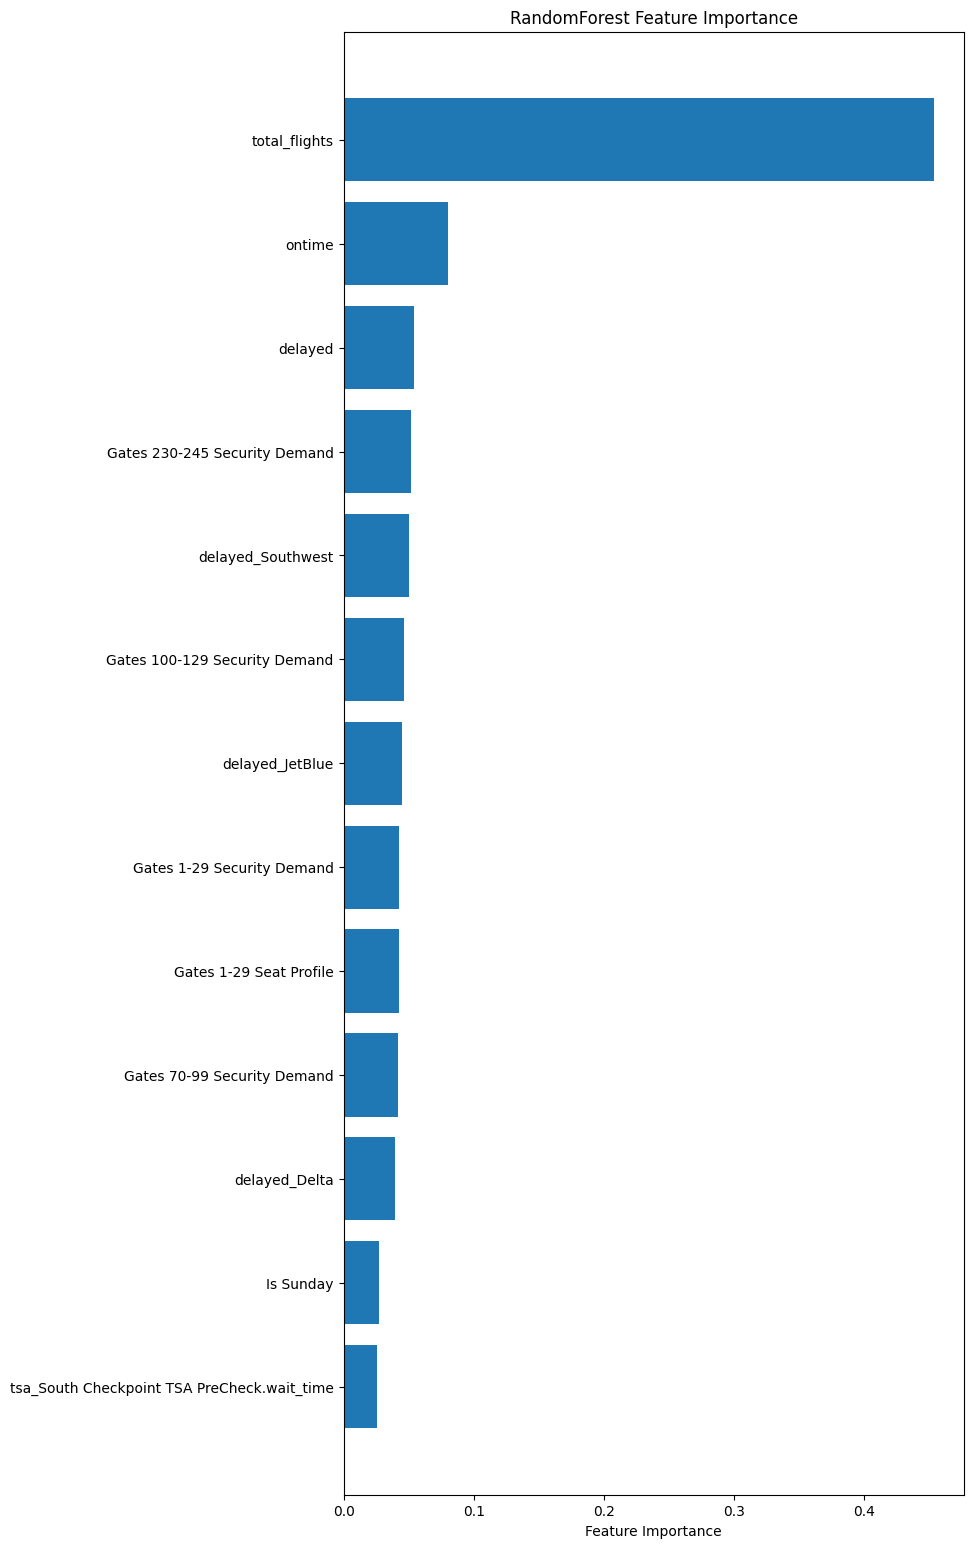

In [15]:
# Feature selection
feature_importances = best_rf.named_steps['randomforestregressor'].feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
print(importance_df)

low_features = importance_df[importance_df['importance'] < 0.02]['feature'].tolist()
print("Features with importance below 0.02:", low_features)

plt.figure(figsize=(8,19))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Feature Importance")
plt.title("RandomForest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()